In [2]:
import numpy as np
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna import Trial, Study
from braindecode.models import EEGNetv4, HybridNet, EEGResNet, TCN, EEGInceptionMI
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.training import train, best_torch_device
from torchinfo import summary
from copy import copy, deepcopy
from prepare_data import get_frequency_dataloader, get_raw_dataloader, get_sub1_dataloader, get_time_series_dataloader
from torch_optimizer import Adahessian

%load_ext autoreload
%autoreload 2

In [32]:
bsz = 64

train_loader, val_loader, test_loader = get_raw_dataloader(batch_size=bsz)
train_aug_loader, _, _ = get_frequency_dataloader(batch_size=bsz)
train_sub_loader, val_sub_loader, test_sub_loader = get_sub1_dataloader(batch_size=bsz)


In [4]:
class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()

        self.tdd = nn.Sequential(
            nn.Linear(22, 40),
            nn.ELU(),
            # nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
        )
        
        self.chnnelwise_linear = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.bn = nn.BatchNorm1d(40)


        self.num_layers = 5 # 3, 4
        self.hidden_size = 50 # 20
        self.lstm = nn.LSTM(
            input_size=40,
            hidden_size=self.hidden_size,
            dropout=0.3,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.linear2 = nn.Sequential(
            nn.Flatten(),
            # nn.LazyLinear(100),
            # nn.ELU(),
            # nn.BatchNorm1d(100),
            nn.LazyLinear(10),
            nn.ELU(),
            nn.BatchNorm1d(10),
            nn.Dropout(0.3),
            nn.LazyLinear(out_features=4),
        )

        self.softmax = nn.Softmax(dim=1)  # the dim corresponds to num_output_classes=4

    def forward(self, x):
        """
        x should have shape (N, H, L) = (N, 22, 1000), where
            L = sequence length
            N = batch size
            H = input size
        """
        x = x.permute(0, 2, 1) # (N, 1000, 22)
        x = self.tdd(x) # (N, 1000, 40)

        x = x.permute(0, 2, 1) # (N, 40, 1000)
        # x = self.chnnelwise_linear(x)
        x = self.bn(x)
        x = x.permute(0, 2, 1)

        # device = torch.device('mps')
        # h0 = torch.randn(self.num_layers, self.hidden_size).to(device)
        # c0 = torch.randn(self.num_layers, self.hidden_size).to(device)
        x, _ = self.lstm(x)

        x = self.linear2(x)

        x = self.softmax(x)
        return x

In [65]:
device = torch.device('mps')

model = RNN()
model = model.to(device)
print(model)
summary(model, input_size=(2, 22, 1000), device='mps')

RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=5, batch_first=True, dropout=0.3)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [2, 4]                    500,500
├─Sequential: 1-1                        [2, 1000, 40]             --
│    └─Linear: 2-1                       [2, 1000, 40]             920
│    └─ELU: 2-2                          [2, 1000, 40]             --
│    └─Dropout: 2-3                      [2, 1000, 40]             --
├─BatchNorm1d: 1-2                       [2, 40, 1000]             80
├─LSTM: 1-3                              [2, 1000, 50]             100,000
├─Sequential: 1-4                        [2, 4]                    --
│    └─Flatten: 2-4                      [2, 50000]                --
│    └─Linear: 2-5                       [2, 10]                   500,010
│    └─ELU: 2-6                          [2, 10]                   --
│    └─BatchNorm1d: 2-7                  [2, 10]                   20
│    └─Dropout: 2-8                      [2, 10]                   --

In [10]:
from utils.training import train

raw_model = model
raw_model.to(device)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/rnn",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 28/28 [00:10<00:00,  2.61batch/s, loss=1.3742]


[Epoch 0] val_acc=0.242604 train_acc=0.261114 val_loss=0.024859 train_loss=0.021977
Validation loss decreased (inf --> 0.024859).  Saving model ...


Epoch 1: 100%|██████████| 28/28 [00:10<00:00,  2.71batch/s, loss=1.3216]


[Epoch 1] val_acc=0.349112 train_acc=0.335397 val_loss=0.024281 train_loss=0.021482
Validation loss decreased (0.024859 --> 0.024281).  Saving model ...


Epoch 2: 100%|██████████| 28/28 [00:10<00:00,  2.70batch/s, loss=1.2952]


[Epoch 2] val_acc=0.384615 train_acc=0.401801 val_loss=0.023678 train_loss=0.020895
Validation loss decreased (0.024281 --> 0.023678).  Saving model ...


Epoch 3: 100%|██████████| 28/28 [00:10<00:00,  2.70batch/s, loss=1.3587]


[Epoch 3] val_acc=0.399408 train_acc=0.458075 val_loss=0.023580 train_loss=0.020517
Validation loss decreased (0.023678 --> 0.023580).  Saving model ...


Epoch 4: 100%|██████████| 28/28 [00:10<00:00,  2.70batch/s, loss=1.2307]


[Epoch 4] val_acc=0.414201 train_acc=0.465954 val_loss=0.023296 train_loss=0.020221
Validation loss decreased (0.023580 --> 0.023296).  Saving model ...


Epoch 5: 100%|██████████| 28/28 [00:10<00:00,  2.56batch/s, loss=1.2498]


[Epoch 5] val_acc=0.405325 train_acc=0.514913 val_loss=0.022816 train_loss=0.019881
Validation loss decreased (0.023296 --> 0.022816).  Saving model ...


Epoch 6: 100%|██████████| 28/28 [00:10<00:00,  2.60batch/s, loss=1.2388]


[Epoch 6] val_acc=0.426036 train_acc=0.541925 val_loss=0.022815 train_loss=0.019552
Validation loss decreased (0.022816 --> 0.022815).  Saving model ...


Epoch 7: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.2436]


[Epoch 7] val_acc=0.434911 train_acc=0.556556 val_loss=0.022844 train_loss=0.019384
EarlyStopping counter: 1 out of 30


Epoch 8: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.2427]


[Epoch 8] val_acc=0.387574 train_acc=0.585256 val_loss=0.023844 train_loss=0.019043
EarlyStopping counter: 2 out of 30


Epoch 9: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=1.2591]


[Epoch 9] val_acc=0.420118 train_acc=0.601576 val_loss=0.022845 train_loss=0.018876
EarlyStopping counter: 3 out of 30


Epoch 10: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=1.1957]


[Epoch 10] val_acc=0.428994 train_acc=0.593134 val_loss=0.022911 train_loss=0.018871
EarlyStopping counter: 4 out of 30


Epoch 11: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=1.2326]


[Epoch 11] val_acc=0.417160 train_acc=0.635903 val_loss=0.023289 train_loss=0.018507
EarlyStopping counter: 5 out of 30


Epoch 12: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.0954]


[Epoch 12] val_acc=0.423077 train_acc=0.669105 val_loss=0.023040 train_loss=0.018059
EarlyStopping counter: 6 out of 30


Epoch 13: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=1.2111]


[Epoch 13] val_acc=0.390533 train_acc=0.674733 val_loss=0.023736 train_loss=0.017847
EarlyStopping counter: 7 out of 30


Epoch 14: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.1442]


[Epoch 14] val_acc=0.426036 train_acc=0.694429 val_loss=0.022911 train_loss=0.017718
EarlyStopping counter: 8 out of 30


Epoch 15: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=1.1277]


[Epoch 15] val_acc=0.411243 train_acc=0.693303 val_loss=0.023369 train_loss=0.017608
EarlyStopping counter: 9 out of 30


Epoch 16: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=1.0612]


[Epoch 16] val_acc=0.393491 train_acc=0.732696 val_loss=0.023275 train_loss=0.017113
EarlyStopping counter: 10 out of 30


Epoch 17: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.0814]


[Epoch 17] val_acc=0.381657 train_acc=0.773776 val_loss=0.023683 train_loss=0.016714
EarlyStopping counter: 11 out of 30


Epoch 18: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=1.1027]


[Epoch 18] val_acc=0.366864 train_acc=0.804727 val_loss=0.023957 train_loss=0.016216
EarlyStopping counter: 12 out of 30


Epoch 19: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.9658]


[Epoch 19] val_acc=0.378698 train_acc=0.803602 val_loss=0.023437 train_loss=0.016302
EarlyStopping counter: 13 out of 30


Epoch 20: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=1.0266]


[Epoch 20] val_acc=0.375740 train_acc=0.833990 val_loss=0.023824 train_loss=0.015850
EarlyStopping counter: 14 out of 30


Epoch 21: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=1.0158]


[Epoch 21] val_acc=0.381657 train_acc=0.870006 val_loss=0.023734 train_loss=0.015460
EarlyStopping counter: 15 out of 30


Epoch 22: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=1.0223]


[Epoch 22] val_acc=0.366864 train_acc=0.870568 val_loss=0.023853 train_loss=0.015398
EarlyStopping counter: 16 out of 30


Epoch 23: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=0.9789]


[Epoch 23] val_acc=0.313609 train_acc=0.877884 val_loss=0.024736 train_loss=0.015240
EarlyStopping counter: 17 out of 30


Epoch 24: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=0.9667]


[Epoch 24] val_acc=0.375740 train_acc=0.889702 val_loss=0.023899 train_loss=0.015051
EarlyStopping counter: 18 out of 30


Epoch 25: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.9899]


[Epoch 25] val_acc=0.363905 train_acc=0.904896 val_loss=0.024109 train_loss=0.014824
EarlyStopping counter: 19 out of 30


Epoch 26: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.9350]


[Epoch 26] val_acc=0.355030 train_acc=0.926843 val_loss=0.024230 train_loss=0.014567
EarlyStopping counter: 20 out of 30


Epoch 27: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=0.9436]


[Epoch 27] val_acc=0.381657 train_acc=0.934159 val_loss=0.023819 train_loss=0.014442
EarlyStopping counter: 21 out of 30


Epoch 28: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.8947]


[Epoch 28] val_acc=0.340237 train_acc=0.912212 val_loss=0.024420 train_loss=0.014681
EarlyStopping counter: 22 out of 30


Epoch 29: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=0.9284]


[Epoch 29] val_acc=0.355030 train_acc=0.947102 val_loss=0.023998 train_loss=0.014224
EarlyStopping counter: 23 out of 30


Epoch 30: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=0.8988]


[Epoch 30] val_acc=0.334320 train_acc=0.960608 val_loss=0.024268 train_loss=0.014127
EarlyStopping counter: 24 out of 30


Epoch 31: 100%|██████████| 28/28 [00:10<00:00,  2.71batch/s, loss=0.8740]


[Epoch 31] val_acc=0.363905 train_acc=0.960608 val_loss=0.024066 train_loss=0.014040
EarlyStopping counter: 25 out of 30


Epoch 32: 100%|██████████| 28/28 [00:10<00:00,  2.68batch/s, loss=0.8953]


[Epoch 32] val_acc=0.393491 train_acc=0.969049 val_loss=0.023974 train_loss=0.013915
EarlyStopping counter: 26 out of 30


Epoch 33: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.9128]


[Epoch 33] val_acc=0.343195 train_acc=0.972425 val_loss=0.024449 train_loss=0.013849
EarlyStopping counter: 27 out of 30


Epoch 34: 100%|██████████| 28/28 [00:10<00:00,  2.60batch/s, loss=0.8832]


[Epoch 34] val_acc=0.360947 train_acc=0.971300 val_loss=0.024123 train_loss=0.013874
EarlyStopping counter: 28 out of 30


Epoch 35: 100%|██████████| 28/28 [00:10<00:00,  2.68batch/s, loss=0.8856]


[Epoch 35] val_acc=0.349112 train_acc=0.977490 val_loss=0.024284 train_loss=0.013790
EarlyStopping counter: 29 out of 30


Epoch 36: 100%|██████████| 28/28 [00:11<00:00,  2.54batch/s, loss=0.8900]


[Epoch 36] val_acc=0.387574 train_acc=0.947665 val_loss=0.023812 train_loss=0.014195
EarlyStopping counter: 30 out of 30
Early stopping.


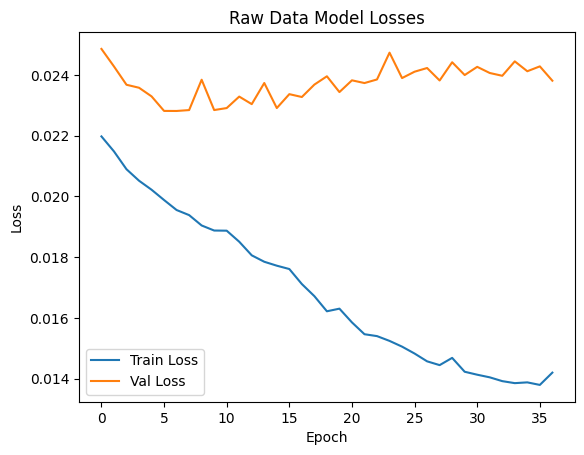

In [11]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

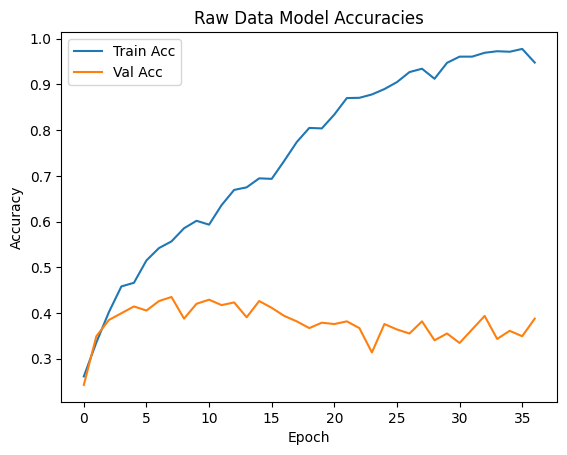

In [12]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
# Load best model and test
raw_model = torch.load("models/rnn/raw.pt")
raw_model.to(device)
raw_model.eval()

RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=4, batch_first=True, dropout=0.5)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10000, out_features=200, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=200, out_features=20, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): 

In [14]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.4221


In [15]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.4200


## Train on Data Augmented with FT Surrogate

In [66]:
aug_model = RNN()
aug_model.to(device)

RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=5, batch_first=True, dropout=0.3)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [67]:
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001, weight_decay=1e-10)
# optimizer = Adahessian(aug_model.parameters(), lr=0.01, weight_decay=1e-10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_aug_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=aug_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/rnn",
    cp_filename="aug.pt",
    n_epochs=100,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 28/28 [00:17<00:00,  1.56batch/s, loss=1.3797]


[Epoch 0] val_acc=0.254438 train_acc=0.250985 val_loss=0.024751 train_loss=0.022161
Validation loss decreased (inf --> 0.024751).  Saving model ...


Epoch 1: 100%|██████████| 28/28 [00:17<00:00,  1.62batch/s, loss=1.4043]


[Epoch 1] val_acc=0.266272 train_acc=0.316263 val_loss=0.024795 train_loss=0.021629
EarlyStopping counter: 1 out of 30


Epoch 2: 100%|██████████| 28/28 [00:16<00:00,  1.67batch/s, loss=1.3621]


[Epoch 2] val_acc=0.316568 train_acc=0.310636 val_loss=0.024454 train_loss=0.021635
Validation loss decreased (0.024751 --> 0.024454).  Saving model ...


Epoch 3: 100%|██████████| 28/28 [00:17<00:00,  1.64batch/s, loss=1.3381]


[Epoch 3] val_acc=0.304734 train_acc=0.335959 val_loss=0.024366 train_loss=0.021526
Validation loss decreased (0.024454 --> 0.024366).  Saving model ...


Epoch 4: 100%|██████████| 28/28 [00:17<00:00,  1.60batch/s, loss=1.3146]


[Epoch 4] val_acc=0.319527 train_acc=0.344401 val_loss=0.024341 train_loss=0.021375
Validation loss decreased (0.024366 --> 0.024341).  Saving model ...


Epoch 5: 100%|██████████| 28/28 [00:16<00:00,  1.70batch/s, loss=1.3587]


[Epoch 5] val_acc=0.328402 train_acc=0.364660 val_loss=0.024242 train_loss=0.021223
Validation loss decreased (0.024341 --> 0.024242).  Saving model ...


Epoch 6: 100%|██████████| 28/28 [00:16<00:00,  1.73batch/s, loss=1.3728]


[Epoch 6] val_acc=0.372781 train_acc=0.362971 val_loss=0.024013 train_loss=0.021298
Validation loss decreased (0.024242 --> 0.024013).  Saving model ...


Epoch 7: 100%|██████████| 28/28 [00:15<00:00,  1.75batch/s, loss=1.3818]


[Epoch 7] val_acc=0.337278 train_acc=0.351154 val_loss=0.024201 train_loss=0.021331
EarlyStopping counter: 1 out of 30


Epoch 8: 100%|██████████| 28/28 [00:16<00:00,  1.72batch/s, loss=1.3154]


[Epoch 8] val_acc=0.363905 train_acc=0.379854 val_loss=0.023694 train_loss=0.021116
Validation loss decreased (0.024013 --> 0.023694).  Saving model ...


Epoch 9: 100%|██████████| 28/28 [00:17<00:00,  1.63batch/s, loss=1.2907]


[Epoch 9] val_acc=0.313609 train_acc=0.393922 val_loss=0.024228 train_loss=0.021012
EarlyStopping counter: 1 out of 30


Epoch 10: 100%|██████████| 28/28 [00:19<00:00,  1.40batch/s, loss=1.3523]


[Epoch 10] val_acc=0.363905 train_acc=0.392797 val_loss=0.023873 train_loss=0.021040
EarlyStopping counter: 2 out of 30


Epoch 11: 100%|██████████| 28/28 [00:20<00:00,  1.38batch/s, loss=1.3051]


[Epoch 11] val_acc=0.372781 train_acc=0.393922 val_loss=0.023727 train_loss=0.020972
EarlyStopping counter: 3 out of 30


Epoch 12: 100%|██████████| 28/28 [00:19<00:00,  1.44batch/s, loss=1.3868]


[Epoch 12] val_acc=0.355030 train_acc=0.398987 val_loss=0.023951 train_loss=0.020915
EarlyStopping counter: 4 out of 30


Epoch 13: 100%|██████████| 28/28 [00:20<00:00,  1.33batch/s, loss=1.3322]


[Epoch 13] val_acc=0.355030 train_acc=0.415307 val_loss=0.023826 train_loss=0.020837
EarlyStopping counter: 5 out of 30


Epoch 14: 100%|██████████| 28/28 [00:17<00:00,  1.56batch/s, loss=1.2738]


[Epoch 14] val_acc=0.378698 train_acc=0.414744 val_loss=0.023728 train_loss=0.020747
EarlyStopping counter: 6 out of 30


Epoch 15: 100%|██████████| 28/28 [00:16<00:00,  1.68batch/s, loss=1.2856]


[Epoch 15] val_acc=0.387574 train_acc=0.443444 val_loss=0.023706 train_loss=0.020543
EarlyStopping counter: 7 out of 30


Epoch 16: 100%|██████████| 28/28 [00:18<00:00,  1.54batch/s, loss=1.2973]


[Epoch 16] val_acc=0.372781 train_acc=0.419809 val_loss=0.023781 train_loss=0.020744
EarlyStopping counter: 8 out of 30


Epoch 17: 100%|██████████| 28/28 [00:19<00:00,  1.45batch/s, loss=1.2778]


[Epoch 17] val_acc=0.381657 train_acc=0.433315 val_loss=0.023627 train_loss=0.020569
Validation loss decreased (0.023694 --> 0.023627).  Saving model ...


Epoch 18: 100%|██████████| 28/28 [00:18<00:00,  1.55batch/s, loss=1.4123]


[Epoch 18] val_acc=0.313609 train_acc=0.405740 val_loss=0.024641 train_loss=0.020752
EarlyStopping counter: 1 out of 30


Epoch 19: 100%|██████████| 28/28 [00:16<00:00,  1.67batch/s, loss=1.2733]


[Epoch 19] val_acc=0.337278 train_acc=0.435003 val_loss=0.024086 train_loss=0.020646
EarlyStopping counter: 2 out of 30


Epoch 20: 100%|██████████| 28/28 [00:17<00:00,  1.63batch/s, loss=1.3275]


[Epoch 20] val_acc=0.387574 train_acc=0.446820 val_loss=0.023431 train_loss=0.020492
Validation loss decreased (0.023627 --> 0.023431).  Saving model ...


Epoch 21: 100%|██████████| 28/28 [00:24<00:00,  1.13batch/s, loss=1.3398]


[Epoch 21] val_acc=0.402367 train_acc=0.456950 val_loss=0.023560 train_loss=0.020336
EarlyStopping counter: 1 out of 30


Epoch 22: 100%|██████████| 28/28 [00:21<00:00,  1.28batch/s, loss=1.2956]


[Epoch 22] val_acc=0.423077 train_acc=0.437817 val_loss=0.023271 train_loss=0.020462
Validation loss decreased (0.023431 --> 0.023271).  Saving model ...


Epoch 23: 100%|██████████| 28/28 [00:20<00:00,  1.34batch/s, loss=1.3593]


[Epoch 23] val_acc=0.408284 train_acc=0.468205 val_loss=0.023240 train_loss=0.020244
Validation loss decreased (0.023271 --> 0.023240).  Saving model ...


Epoch 24: 100%|██████████| 28/28 [00:19<00:00,  1.42batch/s, loss=1.2469]


[Epoch 24] val_acc=0.375740 train_acc=0.467642 val_loss=0.023694 train_loss=0.020183
EarlyStopping counter: 1 out of 30


Epoch 25: 100%|██████████| 28/28 [00:18<00:00,  1.49batch/s, loss=1.3225]


[Epoch 25] val_acc=0.390533 train_acc=0.446258 val_loss=0.023591 train_loss=0.020352
EarlyStopping counter: 2 out of 30


Epoch 26: 100%|██████████| 28/28 [00:18<00:00,  1.55batch/s, loss=1.3167]


[Epoch 26] val_acc=0.405325 train_acc=0.455262 val_loss=0.023420 train_loss=0.020237
EarlyStopping counter: 3 out of 30


Epoch 27: 100%|██████████| 28/28 [00:18<00:00,  1.48batch/s, loss=1.2739]


[Epoch 27] val_acc=0.331361 train_acc=0.446820 val_loss=0.024219 train_loss=0.020305
EarlyStopping counter: 4 out of 30


Epoch 28: 100%|██████████| 28/28 [00:19<00:00,  1.44batch/s, loss=1.2526]


[Epoch 28] val_acc=0.369822 train_acc=0.479460 val_loss=0.023649 train_loss=0.020082
EarlyStopping counter: 5 out of 30


Epoch 29: 100%|██████████| 28/28 [00:17<00:00,  1.57batch/s, loss=1.2694]


[Epoch 29] val_acc=0.355030 train_acc=0.459201 val_loss=0.023964 train_loss=0.020199
EarlyStopping counter: 6 out of 30


Epoch 30: 100%|██████████| 28/28 [00:17<00:00,  1.57batch/s, loss=1.2740]


[Epoch 30] val_acc=0.363905 train_acc=0.461452 val_loss=0.023955 train_loss=0.020135
EarlyStopping counter: 7 out of 30


Epoch 31: 100%|██████████| 28/28 [00:20<00:00,  1.39batch/s, loss=1.2452]


[Epoch 31] val_acc=0.366864 train_acc=0.495217 val_loss=0.023710 train_loss=0.019881
EarlyStopping counter: 8 out of 30


Epoch 32: 100%|██████████| 28/28 [00:17<00:00,  1.57batch/s, loss=1.2469]


[Epoch 32] val_acc=0.322485 train_acc=0.480023 val_loss=0.024126 train_loss=0.020035
EarlyStopping counter: 9 out of 30


Epoch 33: 100%|██████████| 28/28 [00:18<00:00,  1.53batch/s, loss=1.2642]


[Epoch 33] val_acc=0.355030 train_acc=0.464828 val_loss=0.023758 train_loss=0.020183
EarlyStopping counter: 10 out of 30


Epoch 34: 100%|██████████| 28/28 [00:21<00:00,  1.29batch/s, loss=1.2968]


[Epoch 34] val_acc=0.399408 train_acc=0.484524 val_loss=0.023456 train_loss=0.019949
EarlyStopping counter: 11 out of 30


Epoch 35: 100%|██████████| 28/28 [00:22<00:00,  1.25batch/s, loss=1.2141]


[Epoch 35] val_acc=0.349112 train_acc=0.473270 val_loss=0.023954 train_loss=0.020038
EarlyStopping counter: 12 out of 30


Epoch 36: 100%|██████████| 28/28 [00:19<00:00,  1.42batch/s, loss=1.2574]


[Epoch 36] val_acc=0.375740 train_acc=0.494091 val_loss=0.023730 train_loss=0.019950
EarlyStopping counter: 13 out of 30


Epoch 37: 100%|██████████| 28/28 [00:16<00:00,  1.71batch/s, loss=1.2305]


[Epoch 37] val_acc=0.346154 train_acc=0.496905 val_loss=0.023977 train_loss=0.019802
EarlyStopping counter: 14 out of 30


Epoch 38: 100%|██████████| 28/28 [00:16<00:00,  1.69batch/s, loss=1.1992]


[Epoch 38] val_acc=0.355030 train_acc=0.487338 val_loss=0.023859 train_loss=0.019827
EarlyStopping counter: 15 out of 30


Epoch 39: 100%|██████████| 28/28 [00:16<00:00,  1.73batch/s, loss=1.3021]


[Epoch 39] val_acc=0.378698 train_acc=0.481148 val_loss=0.023809 train_loss=0.019934
EarlyStopping counter: 16 out of 30


Epoch 40: 100%|██████████| 28/28 [00:16<00:00,  1.69batch/s, loss=1.2721]


[Epoch 40] val_acc=0.366864 train_acc=0.457513 val_loss=0.024096 train_loss=0.020196
EarlyStopping counter: 17 out of 30


Epoch 41: 100%|██████████| 28/28 [00:16<00:00,  1.67batch/s, loss=1.2506]


[Epoch 41] val_acc=0.313609 train_acc=0.477209 val_loss=0.024677 train_loss=0.019931
EarlyStopping counter: 18 out of 30


Epoch 42: 100%|██████████| 28/28 [00:16<00:00,  1.70batch/s, loss=1.2783]


[Epoch 42] val_acc=0.366864 train_acc=0.467079 val_loss=0.023633 train_loss=0.020041
EarlyStopping counter: 19 out of 30


Epoch 43: 100%|██████████| 28/28 [00:16<00:00,  1.71batch/s, loss=1.2049]


[Epoch 43] val_acc=0.355030 train_acc=0.469893 val_loss=0.023839 train_loss=0.019958
EarlyStopping counter: 20 out of 30


Epoch 44: 100%|██████████| 28/28 [00:18<00:00,  1.55batch/s, loss=1.2824]


[Epoch 44] val_acc=0.390533 train_acc=0.523354 val_loss=0.023337 train_loss=0.019485
EarlyStopping counter: 21 out of 30


Epoch 45: 100%|██████████| 28/28 [00:16<00:00,  1.71batch/s, loss=1.2130]


[Epoch 45] val_acc=0.363905 train_acc=0.514350 val_loss=0.023597 train_loss=0.019602
EarlyStopping counter: 22 out of 30


Epoch 46: 100%|██████████| 28/28 [00:16<00:00,  1.73batch/s, loss=1.1841]


[Epoch 46] val_acc=0.360947 train_acc=0.510974 val_loss=0.023621 train_loss=0.019608
EarlyStopping counter: 23 out of 30


Epoch 47: 100%|██████████| 28/28 [00:18<00:00,  1.49batch/s, loss=1.2194]


[Epoch 47] val_acc=0.357988 train_acc=0.531795 val_loss=0.023525 train_loss=0.019465
EarlyStopping counter: 24 out of 30


Epoch 48: 100%|██████████| 28/28 [00:17<00:00,  1.62batch/s, loss=1.2669]


[Epoch 48] val_acc=0.369822 train_acc=0.515476 val_loss=0.023656 train_loss=0.019562
EarlyStopping counter: 25 out of 30


Epoch 49: 100%|██████████| 28/28 [00:16<00:00,  1.67batch/s, loss=1.2541]


[Epoch 49] val_acc=0.396450 train_acc=0.508160 val_loss=0.023534 train_loss=0.019648
EarlyStopping counter: 26 out of 30


Epoch 50: 100%|██████████| 28/28 [00:16<00:00,  1.69batch/s, loss=1.2531]


[Epoch 50] val_acc=0.402367 train_acc=0.517727 val_loss=0.023602 train_loss=0.019478
EarlyStopping counter: 27 out of 30


Epoch 51: 100%|██████████| 28/28 [00:16<00:00,  1.72batch/s, loss=1.1720]


[Epoch 51] val_acc=0.393491 train_acc=0.532921 val_loss=0.023475 train_loss=0.019408
EarlyStopping counter: 28 out of 30


Epoch 52: 100%|██████████| 28/28 [00:17<00:00,  1.60batch/s, loss=1.2503]


[Epoch 52] val_acc=0.378698 train_acc=0.511536 val_loss=0.023508 train_loss=0.019562
EarlyStopping counter: 29 out of 30


Epoch 53: 100%|██████████| 28/28 [00:20<00:00,  1.36batch/s, loss=1.1737]


[Epoch 53] val_acc=0.384615 train_acc=0.530107 val_loss=0.023491 train_loss=0.019277
EarlyStopping counter: 30 out of 30
Early stopping.


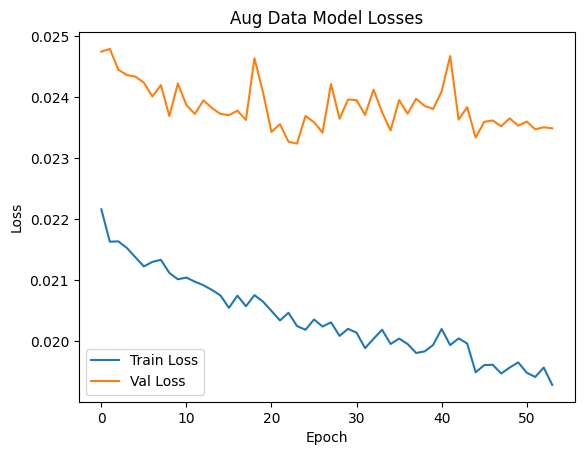

In [69]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Aug Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

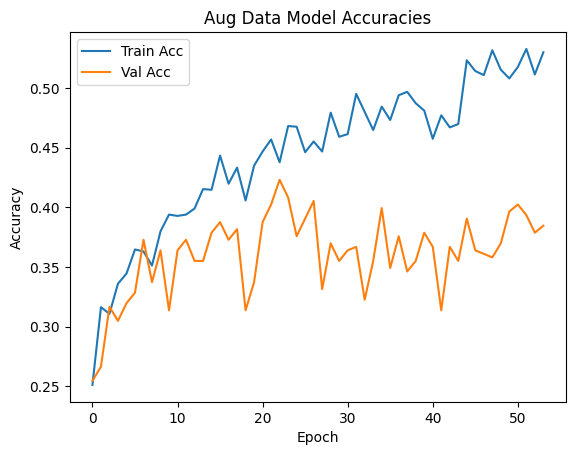

In [68]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Aug Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [37]:
# Load best model and test
aug_model = torch.load("models/rnn/aug_41.pt")
aug_model.to(device)
aug_model.eval()

RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=5, batch_first=True, dropout=0.3)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50000, out_features=10, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=10, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [38]:
# Evaluate on aug data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on aug data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on aug data, evaluate on raw data
Test Acc: 0.4108


In [39]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on aug data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on aug data, evaluate on sub1 data
Test Acc: 0.3600


# Train on Sub 1 Data

In [6]:
device = torch.device('mps')

model = RNN()
model = model.to(device)
print(model)
summary(model, input_size=(1, 22, 1000), device='mps')

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=5, batch_first=True, dropout=0.3)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 4]                    500,500
├─Sequential: 1-1                        [1, 1000, 40]             --
│    └─Linear: 2-1                       [1, 1000, 40]             920
│    └─ELU: 2-2                          [1, 1000, 40]             --
│    └─Dropout: 2-3                      [1, 1000, 40]             --
├─BatchNorm1d: 1-2                       [1, 40, 1000]             80
├─LSTM: 1-3                              [1, 1000, 50]             100,000
├─Sequential: 1-4                        [1, 4]                    --
│    └─Flatten: 2-4                      [1, 50000]                --
│    └─Linear: 2-5                       [1, 10]                   500,010
│    └─ELU: 2-6                          [1, 10]                   --
│    └─BatchNorm1d: 2-7                  [1, 10]                   20
│    └─Dropout: 2-8                      [1, 10]                   --

In [8]:
sub_model = model
sub_model.to(device)

optimizer = torch.optim.Adam(sub_model.parameters(), lr=0.001,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_sub_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/rnn",
    cp_filename="sub.pt",
    n_epochs=100,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.27batch/s, loss=1.3319]


[Epoch 0] val_acc=0.301775 train_acc=0.949749 val_loss=0.024255 train_loss=0.022517
Validation loss decreased (inf --> 0.024255).  Saving model ...


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.33batch/s, loss=1.1258]


[Epoch 1] val_acc=0.310651 train_acc=0.939698 val_loss=0.024127 train_loss=0.021632
Validation loss decreased (0.024255 --> 0.024127).  Saving model ...


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.42batch/s, loss=1.3655]


[Epoch 2] val_acc=0.331361 train_acc=0.924623 val_loss=0.024061 train_loss=0.022659
Validation loss decreased (0.024127 --> 0.024061).  Saving model ...


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.36batch/s, loss=1.1257]


[Epoch 3] val_acc=0.349112 train_acc=0.944724 val_loss=0.024005 train_loss=0.021622
Validation loss decreased (0.024061 --> 0.024005).  Saving model ...


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.39batch/s, loss=1.0674]


[Epoch 4] val_acc=0.322485 train_acc=0.954774 val_loss=0.024104 train_loss=0.021120
EarlyStopping counter: 1 out of 30


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.37batch/s, loss=0.9880]


[Epoch 5] val_acc=0.301775 train_acc=0.979899 val_loss=0.024261 train_loss=0.020357
EarlyStopping counter: 2 out of 30


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.37batch/s, loss=1.0300]


[Epoch 6] val_acc=0.307692 train_acc=0.979899 val_loss=0.024257 train_loss=0.020443
EarlyStopping counter: 3 out of 30


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.38batch/s, loss=0.9669]


[Epoch 7] val_acc=0.322485 train_acc=0.974874 val_loss=0.024173 train_loss=0.020101
EarlyStopping counter: 4 out of 30


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.39batch/s, loss=1.0451]


[Epoch 8] val_acc=0.319527 train_acc=0.974874 val_loss=0.024199 train_loss=0.020509
EarlyStopping counter: 5 out of 30


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.31batch/s, loss=1.0401]


[Epoch 9] val_acc=0.310651 train_acc=0.974874 val_loss=0.024295 train_loss=0.020381
EarlyStopping counter: 6 out of 30


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.38batch/s, loss=1.0453]


[Epoch 10] val_acc=0.307692 train_acc=0.974874 val_loss=0.024303 train_loss=0.020301
EarlyStopping counter: 7 out of 30


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.32batch/s, loss=0.9829]


[Epoch 11] val_acc=0.307692 train_acc=0.974874 val_loss=0.024311 train_loss=0.019995
EarlyStopping counter: 8 out of 30


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.32batch/s, loss=1.0125]


[Epoch 12] val_acc=0.298817 train_acc=0.989950 val_loss=0.024494 train_loss=0.020045
EarlyStopping counter: 9 out of 30


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.39batch/s, loss=1.0231]


[Epoch 13] val_acc=0.292899 train_acc=0.984925 val_loss=0.024495 train_loss=0.020044
EarlyStopping counter: 10 out of 30


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.36batch/s, loss=1.0312]


[Epoch 14] val_acc=0.295858 train_acc=0.979899 val_loss=0.024418 train_loss=0.019911
EarlyStopping counter: 11 out of 30


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.30batch/s, loss=0.9680]


[Epoch 15] val_acc=0.331361 train_acc=0.969849 val_loss=0.024306 train_loss=0.019839
EarlyStopping counter: 12 out of 30


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.36batch/s, loss=1.0021]


[Epoch 16] val_acc=0.331361 train_acc=0.989950 val_loss=0.024275 train_loss=0.019758
EarlyStopping counter: 13 out of 30


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.43batch/s, loss=1.0338]


[Epoch 17] val_acc=0.313609 train_acc=0.984925 val_loss=0.024243 train_loss=0.020020
EarlyStopping counter: 14 out of 30


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.40batch/s, loss=1.2437]


[Epoch 18] val_acc=0.319527 train_acc=0.979899 val_loss=0.024294 train_loss=0.020822
EarlyStopping counter: 15 out of 30


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.41batch/s, loss=1.0295]


[Epoch 19] val_acc=0.316568 train_acc=0.979899 val_loss=0.024366 train_loss=0.019671
EarlyStopping counter: 16 out of 30


Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.38batch/s, loss=1.1110]


[Epoch 20] val_acc=0.316568 train_acc=0.979899 val_loss=0.024285 train_loss=0.020407
EarlyStopping counter: 17 out of 30


Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.32batch/s, loss=0.9406]


[Epoch 21] val_acc=0.322485 train_acc=0.989950 val_loss=0.024203 train_loss=0.019304
EarlyStopping counter: 18 out of 30


Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.33batch/s, loss=0.9571]


[Epoch 22] val_acc=0.301775 train_acc=0.979899 val_loss=0.024207 train_loss=0.019327
EarlyStopping counter: 19 out of 30


Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.26batch/s, loss=0.9504]


[Epoch 23] val_acc=0.289941 train_acc=0.974874 val_loss=0.024377 train_loss=0.019191
EarlyStopping counter: 20 out of 30


Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.34batch/s, loss=1.0416]


[Epoch 24] val_acc=0.307692 train_acc=0.989950 val_loss=0.024329 train_loss=0.019648
EarlyStopping counter: 21 out of 30


Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.41batch/s, loss=1.0410]


[Epoch 25] val_acc=0.313609 train_acc=0.989950 val_loss=0.024189 train_loss=0.019489
EarlyStopping counter: 22 out of 30


Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.38batch/s, loss=0.9625]


[Epoch 26] val_acc=0.316568 train_acc=0.979899 val_loss=0.024215 train_loss=0.019137
EarlyStopping counter: 23 out of 30


Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.36batch/s, loss=1.0093]


[Epoch 27] val_acc=0.292899 train_acc=0.984925 val_loss=0.024342 train_loss=0.019412
EarlyStopping counter: 24 out of 30


Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.40batch/s, loss=0.9453]


[Epoch 28] val_acc=0.278107 train_acc=0.984925 val_loss=0.024492 train_loss=0.018996
EarlyStopping counter: 25 out of 30


Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.37batch/s, loss=0.9183]


[Epoch 29] val_acc=0.316568 train_acc=0.994975 val_loss=0.024344 train_loss=0.018849
EarlyStopping counter: 26 out of 30


Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.37batch/s, loss=0.9483]


[Epoch 30] val_acc=0.328402 train_acc=0.994975 val_loss=0.024237 train_loss=0.018974
EarlyStopping counter: 27 out of 30


Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.39batch/s, loss=0.9719]


[Epoch 31] val_acc=0.328402 train_acc=0.994975 val_loss=0.024190 train_loss=0.019008
EarlyStopping counter: 28 out of 30


Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.38batch/s, loss=1.0327]


[Epoch 32] val_acc=0.319527 train_acc=0.994975 val_loss=0.024168 train_loss=0.019179
EarlyStopping counter: 29 out of 30


Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.39batch/s, loss=0.9711]


[Epoch 33] val_acc=0.322485 train_acc=1.000000 val_loss=0.024206 train_loss=0.018961
EarlyStopping counter: 30 out of 30
Early stopping.


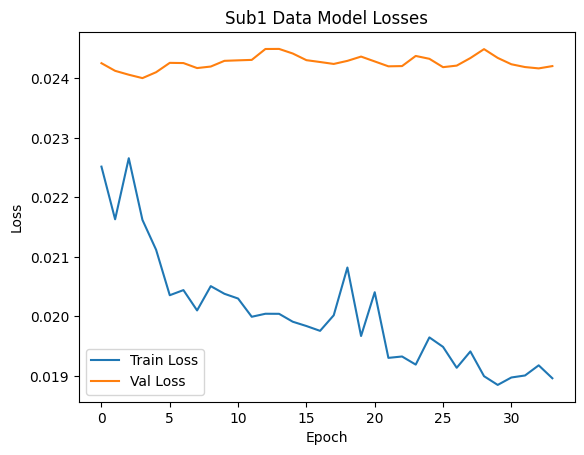

In [9]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

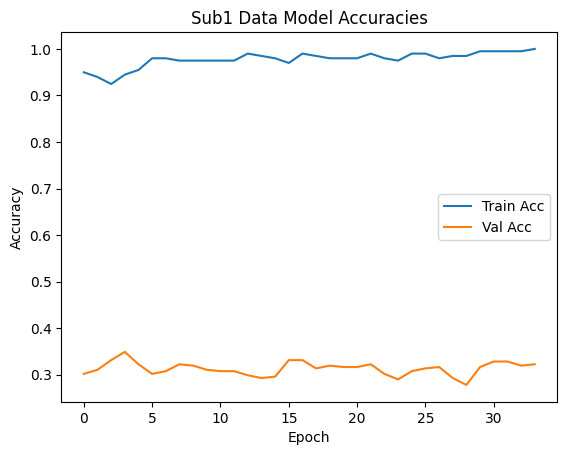

In [10]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [11]:
# Load best model and test
sub1_model = torch.load("models/rnn/sub.pt")
sub1_model.to(device)
sub1_model.eval()

RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=5, batch_first=True, dropout=0.3)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50000, out_features=10, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=10, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [12]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.2400


## Time Series

In [13]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [15]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = RNN()
    time_model.to(device)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=30,
        cp_path="models/rnn",
        cp_filename=f"time_{ts}.pt",
        n_epochs=100,
        show_progress_bar=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/rnn/time_{ts}.pt")
    time_model.to(device)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps
[Epoch 0] val_acc=0.316568 train_acc=0.293754 val_loss=0.024374 train_loss=0.021795
Validation loss decreased (inf --> 0.024374).  Saving model ...
[Epoch 1] val_acc=0.337278 train_acc=0.344963 val_loss=0.024070 train_loss=0.021408
Validation loss decreased (0.024374 --> 0.024070).  Saving model ...
[Epoch 2] val_acc=0.381657 train_acc=0.370287 val_loss=0.023973 train_loss=0.021223
Validation loss decreased (0.024070 --> 0.023973).  Saving model ...
[Epoch 3] val_acc=0.357988 train_acc=0.360720 val_loss=0.023903 train_loss=0.021260
Validation loss decreased (0.023973 --> 0.023903).  Saving model ...
[Epoch 4] val_acc=0.384615 train_acc=0.384918 val_loss=0.023858 train_loss=0.021124
Validation loss decreased (0.023903 --> 0.023858).  Saving model ...
[Epoch 5] val_acc=0.349112 train_acc=0.384356 val_loss=0.023924 train_loss=0.021157
EarlyStopping counter: 1 out of 30
[Epoch 6] val_acc=0.331361 train_acc=0.371412 val_loss=0.024082 train_loss=0.021119
EarlyStopping count

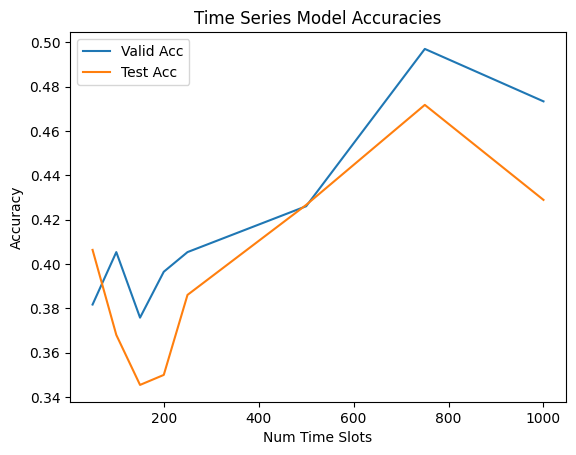

In [16]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()